# Analysis of Austin Animal Center Shelter Outcome dataset
Trying to model the outcomes of animals at the Austin Animal Center Shelter, using the [Austin Animal Center Shelter Income and Outcome dataset (Kaggle).](https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes) <br>

By Dar Mendelowitz

## Imports

In [60]:
# Data processing
import pandas as pd
import numpy as np

# Statistics
from scipy.stats import chi2_contingency

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning library
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
# import shap

# Helper functions
from utils import print_animal_count, convert_to_years
from utils import get_top_k, set_top_k_colors, sort_colors, set_top_k_breeds
from missing_values import print_animal_ids, get_missing_animal_ids, get_existing_animal_ids_in_dataset
from missing_values import filter_null_values, update_column
from train_model import fit_and_predict

import warnings
warnings.filterwarnings("ignore")

## Loading the Austin Animal Center Shelter Outcome dataset

In [61]:
# Loading the CSV dataset
df_in_out = pd.read_csv("./data/aac_intakes_outcomes.csv")
df_in = pd.read_csv("./data/aac_intakes.csv")
df_out = pd.read_csv("./data/aac_outcomes.csv")
dtf = df_out

# Defining the columns
cols = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'date_of_birth', 'datetime',
        'monthyear', 'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome']
dtf = dtf[cols]

In [62]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [63]:
dtf.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,80673,80681,80681,80681,80681,80681,80681,80681,56116,36893,80667,80679
unique,46,72877,5,2176,532,5956,66474,66474,14824,19,9,5
top,1 year,A721033,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14911,13,45856,23821,8396,112,39,39,362,20082,34232,28702


In the table above, the number of animals in the shelter is 80681 (the count of unique 'animal_id' entries). However, not all columns contain 80681 values, as some entries are missing (NaN values).

For instance:

* The column 'age_upon_outcome' contains slightly fewer values, specifically 80673 entries.
* The 'name' column has significantly fewer entries, totaling 56116.
* In the 'outcome_subtype' column, there are even fewer entries, with only 36893 values present, which is less than half of the total number of animals in the shelter.
* Additionally, both the 'outcome_type' and 'sex_upon_outcome' columns have fewer entries.

Moreover, the number of unique 'animal_id' entries is less than the overall number of 'animal_id' entries (72877 < 80681). This discrepancy occurs because some animals have returned to the shelter. For example, a cat named Elsa (animal_id: A684460) was initially adopted (first outcome) at the age of 2 months. However, she was later returned to the shelter (sadly, her owner surrendered her at the age of 1 year, according to the aac_intakes_outcomes.csv table). After 25 days, Elsa was transferred to another shelter (second outcome).

***

### A first examination of the target feature - 'outcome_type':

A histogram of the target feature 'outcome_type':

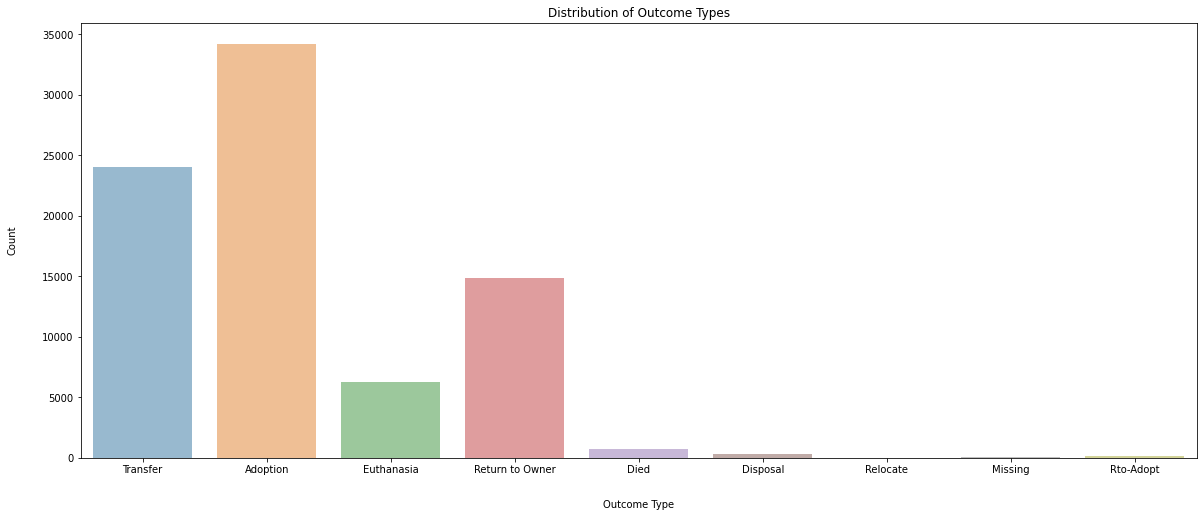

In [64]:
plt.figure(figsize=(20, 8))
sns.countplot(data=dtf, x='outcome_type', alpha=0.5)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type', labelpad=25)
plt.ylabel('Count', labelpad=25)
plt.show()

We can see that most animals were adopted (almost 35,000 animals). Almost 25,000 animals were transfered (to another shelter), about 15,000 were returned to their original owners, a little bit more than 5000 were euthanized. A small number of animals have died, an even smaller number were disposed, relocated, missing or Rto-Adopted.

Overall, most animals either were adopted, transfered, returned to owner or euthanized.

In [65]:
outcome_list = ['Return to Owner', 'Transfer', 'Adoption', 'Euthanasia', 'Died', 'Rto-Adopt', 'Missing',
                'Disposal', 'Relocate']

***

## Data Pre-Processing

***Feature engineering and data cleansing.***

### Outcome Type Distribution

Counting the number of outcome types:

In [66]:
print_animal_count(dtf, 'outcome_type')

      outcome_type  count  percentage
0         Adoption  34232   42.436188
8         Transfer  24050   29.813926
6  Return to Owner  14851   18.410255
3       Euthanasia   6289    7.796249
1             Died    699    0.866525
2         Disposal    304    0.376858
7        Rto-Adopt    179    0.221900
4          Missing     47    0.058264
5         Relocate     16    0.019835


According to the Austin Animal Center Shelter website, 'Rto-Adopt' is when an animal is returned to their owner (Rto=return to owner), usually after it was lost, taken in the shelter as a stray and the shelter was able to locate a chip that led to the owner. Since there aren't a lot of samples of the 'Rto-Adopt' instance and it's the same as 'Return to Owner outcome', I've decided to combine both outcome types:

In [67]:
# Replace 'Rto-Adopt' with 'Return to Owner' in the 'outcome_type' column
dtf['outcome_type'] = dtf['outcome_type'].replace('Rto-Adopt', 'Return to Owner')

Removing all instances with less than 1% samples in the dataset - 'Died', 'Disposal', 'Missing' and 'Relocate':

In [68]:
dtf = dtf[(dtf['outcome_type'] != 'Died') & 
          (dtf['outcome_type'] != 'Disposal') & 
          (dtf['outcome_type'] != 'Missing') & 
          (dtf['outcome_type'] != 'Relocate')]

After change:

In [69]:
print_animal_count(dtf, 'outcome_type')

      outcome_type  count  percentage
0         Adoption  34232   43.004485
3         Transfer  24050   30.213188
2  Return to Owner  15030   18.881672
1       Euthanasia   6289    7.900655


The model will predict one of these four possible outcome types as the outcome of an animal listed in the dataset.

***

### Outcome Subtype Distribution

Counting the number of outcome subtype:

In [70]:
print_animal_count(dtf, 'outcome_subtype')

        outcome_subtype  count  percentage
8               Partner  20082   55.403206
5                Foster   5714   15.764063
10                 SCRP   3211    8.858664
12            Suffering   2563    7.070930
9           Rabies Risk   2546    7.024030
11                  Snr    755    2.082931
0            Aggressive    508    1.401495
7               Offsite    367    1.012498
6               Medical    268    0.739372
3              Behavior    142    0.391757
1                At Vet     37    0.102077
13             Underage     28    0.077248
4   Court/Investigation     23    0.063454
2                  Barn      3    0.008277


Removing all instances with less than 1% samples in the dataset - 'Medical', 'Behavior', 'At Vet', 'Underage', 'Court/Investigation' and 'Barn':

In [71]:
dtf = dtf[(dtf['outcome_subtype'] != 'Medical') & 
          (dtf['outcome_subtype'] != 'Behavior') & 
          (dtf['outcome_subtype'] != 'At Vet') & 
          (dtf['outcome_subtype'] != 'Underage') & 
          (dtf['outcome_subtype'] != 'Court/Investigation') &
          (dtf['outcome_subtype'] != 'Barn')]

***

### Animal Type Distribution

Counting the number of each animal type:

In [72]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
2         Dog  45444   57.441161
1         Cat  29493   37.279116
4       Other   3869    4.890411
0        Bird    298    0.376672
3   Livestock     10    0.012640


We can see that the two most common animals in the shelter are cats and dogs (57.38% of animals in the shelter are dogs and 37.31% are cats).
Other kind of animals (including a variety of different animals - small mammal such as bats, racoons and rabbits, wild animals such as bobcats and deers, and also reptiles and arachnids) make just 4.9% of animals in the shelter. Birds and livestock contribute less than 1%. For simplicity, I've opted to categorize birds and livestock under the 'Other' classification.

Combining birds and livestock under the 'Other' animal type classification:

In [73]:
# Replace 'Livestock' and 'Bird' with 'Other' in the 'animal_type' column
dtf['animal_type'] = dtf['animal_type'].replace(['Livestock', 'Bird'], 'Other')

Counting the number of animals:

In [74]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
1         Dog  45444   57.441161
0         Cat  29493   37.279116
2       Other   4177    5.279723


Now there are only three animal groups in the dataset - cats, dogs and other.

***

### Missing values

How many values are missing?

In [75]:
dtf.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23513
outcome_subtype     43368
outcome_type           14
sex_upon_outcome        2
dtype: int64

There are 8 missing values in the 'age_upon_outcome' column, 14 in the 'outcome_type' column, and 2 in the 'sex_upon_outcome' column, all of which can be addressed relatively easily (for instance, some missing data may be found in the 'in_out_df' dataset). However, the primary challenge lies in managing the extensive amount of missing data in the 'name' and 'outcome_subtype' columns.

Some missing values could potentially be recovered from the aac_intakes_outcomes.csv dataset and the aac_intakes.csv dataset. While columns such as 'age_upon_outcome', 'outcome_type', and 'sex_upon_outcome' contain only a few missing values, it is worth searching for any existing missing data that might be present in the other datasets (besides searching for missing data of the two major sparse columns - 'name' and 'outcome_subtype').

***

#### Missing values of 'age_upon_outcome'

In [76]:
column_name = 'age_upon_outcome'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

In [77]:
# Find all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_age)

# Selecting the existing 'animal_id' values from missing_animal_ids_age based on existence in the filtered df_in_out
existing_animal_id_age = get_existing_animal_ids_in_dataset(df_in_out, column_name, missing_animal_ids_age, df_id)
print_animal_ids(column_name, existing_animal_id_age, 'df_in_out')

Animal IDs with missing values in 'age_upon_outcome' column:
71248    A737705
80344    A768766
80541    A768782
80544    A769181
80548    A769209
80608    A769277
80628    A768281
80664    A769101
Name: animal_id, dtype: object

Animal IDs with missing values in 'age_upon_outcome' column that exist in df_in_out dataset:
80541    A768782
Name: animal_id, dtype: object



Retrieving the missing value, updating the dataset and removing missing values:

In [78]:
# Retrieving the missing value and updating the 'age_upon_outcome' column with the new value
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_age, df_id)

# Geting all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)

# Filtering dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_age)]

***

#### Missing values of 'outcome_type'

In [79]:
column_name = 'outcome_type'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

In [80]:
# Find all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_outcome)

# Selecting the existing 'animal_id' values from missing_animal_ids_outcome based on existence in the filtered df_in_out
existing_animal_id_outcome = get_existing_animal_ids_in_dataset(df_in_out, column_name, missing_animal_ids_outcome, df_id)

# Filtering out any null values
existing_animal_id_outcome = filter_null_values(df_in_out, column_name, existing_animal_id_outcome, outcome_list, df_id)

print_animal_ids(column_name, existing_animal_id_outcome, 'df_in_out')

Animal IDs with missing values in 'outcome_type' column:
8056     A671017
9951     A674209
9975     A679066
12758    A686025
30969    A744013
55432    A718046
64762    A737930
67535    A755711
72899    A755715
75152    A755716
80590    A769260
80598    A769266
Name: animal_id, dtype: object

Animal IDs with missing values in 'outcome_type' column that exist in df_in_out dataset:
64762    A737930
67535    A755711
72899    A755715
75152    A755716
Name: animal_id, dtype: object



Retrieving the missing values, updating the dataset and removing missing values:

In [81]:
# Retrieving the missing values and updating the 'outcome_type' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_outcome, df_id)

# Get all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)

# Filter dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_outcome)]

***

#### Missing values of 'sex_upon_outcome'

--------------------maybe just delete in the first place... there aren't many samples missing

In [82]:
column_name = 'sex_upon_outcome'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

In [83]:
# Find all 'animal_id' of rows with None values in the 'sex_upon_outcome' column
missing_animal_ids_outcome_sex = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_outcome_sex)

# Selecting the existing 'animal_id' values from missing_animal_ids_outcome_sex
# based on existence in the filtered df_in_out
existing_animal_id_outcome_sex = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                    missing_animal_ids_outcome_sex, df_id)
print_animal_ids(column_name, existing_animal_id_outcome_sex, 'df_in_out')

Animal IDs with missing values in 'sex_upon_outcome' column:
12248    A667395
Name: animal_id, dtype: object

Animal IDs with missing values in 'sex_upon_outcome' column that exist in df_in_out dataset:
Series([], Name: animal_id, dtype: object)



There is no existing data in df_in_out dataset (that matches the missing value in the 'sex_upon_outcome' column). The missing row will just be removed from the dtf dataset:

In [84]:
# Finding the 'animal_id' that doesn't exist in df_in_out
missing_animal_id_outcome_sex = missing_animal_ids_outcome_sex.iloc[0]

# Filter dtf to exclude the row with the 'animal_id' value of missing_animal_id_outcome_sex
dtf = dtf.drop(dtf[dtf['animal_id'] == missing_animal_id_outcome_sex].index)

***

#### Missing values of 'outcome_subtype'

In [85]:
column_name = 'outcome_subtype'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

-----------------Takes ~50s - add skip option

In [86]:
sub_outcome_list = dtf['outcome_subtype'].dropna().unique()

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_sub)

# Selecting the existing 'animal_id' values from missing_animal_ids_sub based on existence in the filtered df_in_out
existing_animal_id_sub = get_existing_animal_ids_in_dataset(df_in_out, column_name, missing_animal_ids_sub, df_id)

# Filtering out any null values
existing_animal_id_sub = filter_null_values(df_in_out, column_name, existing_animal_id_sub, sub_outcome_list, df_id)

print_animal_ids(column_name, existing_animal_id_sub, 'df_in_out')

Animal IDs with missing values in 'outcome_subtype' column:
2        A675708
6        A685067
8        A675405
11       A640655
15       A684460
          ...   
80676    A769131
80677    A665594
80678    A769120
80679    A764644
80680    A768726
Name: animal_id, Length: 43357, dtype: object

Animal IDs with missing values in 'outcome_subtype' column that exist in df_in_out dataset:
15       A684460
29       A665344
84       A675373
91       A681449
224      A685958
          ...   
79964    A767718
79967    A767718
80199    A763701
80367    A768895
80418    A767357
Name: animal_id, Length: 1784, dtype: object



Retrieving the missing value and updating the dataset, while defining a default outcome subtype for missing values:

---------------------Takes ~1-2minutes - add skip option

In [87]:
# Retrieving the missing values and updating the 'outcome_subtype' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_sub, df_id)

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)

# Define a default value for missing values in 'outcome_subtype' column
default_subtype = "Unknown"

# Set the default value for 'outcome_subtype' where 'animal_id' matches any element in missing_animal_ids_sub
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_sub), column_name] = default_subtype

I refrained from simply duplicating the values from the 'outcome_type' column and substituting them with missing values in the 'outcome_subtype' column, respectively. My rationale behind this decision was to avoid artificially inflating the importance of those instances. By replicating the same value twice within a single row for certain entries in the dataset, it could potentially skew the significance of those instances compared to others. I opted to assign a default value of 'Unknown' instead.

***

#### Missing values of 'name'

In [88]:
column_name = 'name'
df_id = 'animal_id'

Checking if the missing 'animal_id' values exist in df_in (using the aac_intakes.csv dataset):

In [89]:
# Find all 'animal_id' of rows with None values in the 'name' column
missing_animal_ids_name = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_name)

# Selecting the existing 'animal_id' values from missing_animal_ids_name based on existence in the filtered df_in
existing_animal_id_name = get_existing_animal_ids_in_dataset(df_in, column_name, missing_animal_ids_name, df_id)
print_animal_ids(column_name, existing_animal_id_name, 'df_in')

Animal IDs with missing values in 'name' column:
0        A684346
4        A683115
14       A670420
16       A673952
19       A669621
          ...   
80661    A769130
80662    A769322
80665    A769321
80669    A769320
80673    A769127
Name: animal_id, Length: 23501, dtype: object

Animal IDs with missing values in 'name' column that exist in df_in dataset:
Series([], Name: animal_id, dtype: object)



There is no existing data in df_in dataset (that matches the missing values in the 'name' column).

Animals without a name will be given a default name. The reason that I chose to give them a default name (rather than just deleting the rows with the missing values) is that there might be a reason why these animals weren't given a name, and the fact that they don't have a name might predict their outcome. For example, rabid animals that are being euthanized aren't being named.

Missing values in the df_in dataset:

In [90]:
df_in['name'].isnull().sum()

24584

We can see that the number of missing names in the df_in dataset is similar to the number of missing names in the dtf dataset - 24584 in df_in vs. 24553 in dtf before eliminating some of the 'outcome_type'/'outcome_subtype' instances, and 23501 in dtf after eliminating instances in the 'outcome_type'/'outcome_subtype' columns (some of the animals were just taken in the shelter and nothing changed since that, so they don't have any outcome recorded, and therefore don't appear in the outcome dataset dtf, which can explains the difference in the numbers).

Some animals in the shelter have a name, and some don't. The name itself doesn't really predict the outcome of the animal, but the fact that the animal has a name does. For this reason I've decided to convert the 'name' column to a 'binary' column ('Yes' or 'No') if an animal has a name or if it doesn't:

In [91]:
# Rename the column 'name' to 'is_named'
dtf.rename(columns={'name': 'is_named'}, inplace=True)

# Define a default value for the 'is_named' column (that will be replaced)
default_name = "Unknown"

# Set the default value for 'is_named' where 'animal_id' matches any element in missing_animal_ids_name
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_name), 'is_named'] = default_name

dtf['is_named'] = np.where(dtf['is_named'].str.contains('Unknown'), 'No', 'Yes')

***

#### Missing values - Conclusion:

How many values are missing now?

In [92]:
dtf.isnull().sum()

age_upon_outcome    0
animal_id           0
animal_type         0
breed               0
color               0
date_of_birth       0
datetime            0
monthyear           0
is_named            0
outcome_subtype     0
outcome_type        0
sex_upon_outcome    0
dtype: int64

Now there are no missing values in the dataset.

***

### Additional Feature Engineering

#### Converting 'age_upon_outcome' column to a numeric column:

In [93]:
# Apply the function convert_to_years to the 'age_upon_outcome' column
dtf['age_upon_outcome'] = dtf['age_upon_outcome'].apply(convert_to_years)

***

#### Deleting 'date_of_birth' column:

Each animal's age is provided in the dataset. Given the variability in the accuracy of birth dates, as indicated by the Austin Animal Center Shelter website, it's more practical to represent an animal's age in a numeric format rather than relying on a datetime format to denote the day of birth. This approach accommodates instances where birth dates are uncertain or assessed, ensuring greater consistency and convenience for analysis.

In [94]:
# Removing 'date_of_birth' column from dtf
dtf = dtf.drop('date_of_birth', axis=1)

***

#### Deleteing 'monthyear' column:

In [95]:
datetime = dtf['datetime']
monthyear = dtf['monthyear']

# Check if the two columns are equal
are_equal = (datetime == monthyear).all()

# Print the result
if are_equal:
    print("The columns 'datetime' and 'monthyear' are equal")
else:
    print("Not equal")

The columns 'datetime' and 'monthyear' are equal


Since 'datetime' and 'monthyear' are two equal columns, I've decided to delete one of them - 'monthyear':

In [96]:
# Remove column 'monthyear'
dtf = dtf.drop('monthyear', axis=1)

***

#### Converting 'datatime' column into numeric columns:

Replacing the column 'datetime' into five columns - 'outcome_year' (year of outcome), 'outcome_month' (month of outcome) 'outcome_date' (day in the month of outcome), 'outcome_weekday' (day in the week of outcome),  and 'outcome_hour' (hour of outcome):

In [97]:
# Converting 'outcome_date' into datetime
dtf['datetime'] = pd.to_datetime(dtf['datetime'])

dtf['outcome_year'] = dtf['datetime'].dt.year
dtf['outcome_month'] = dtf['datetime'].dt.month
dtf['outcome_date'] = dtf['datetime'].dt.daysinmonth
dtf['outcome_weekday'] = dtf['datetime'].dt.dayofweek
dtf['outcome_hour'] = dtf['datetime'].dt.hour

# Rearranging the columns in dtf
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'outcome_year',
                'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named',
                'outcome_subtype', 'outcome_type', 'sex_upon_outcome']
dtf = dtf[column_order]

***

#### Color Distribution

Top 15 cat colors:

In [98]:
top_k_cat_colors = pd.DataFrame(get_top_k(dtf, 'color', 'Cat', 15))
top_k_cat_colors.head(15)

,count,percentage
Brown Tabby,4453,15.100034
Black,3843,13.031536
Black/White,2784,9.440488
Brown Tabby/White,2345,7.951848
Orange Tabby,2188,7.419464
Tortie,1360,4.611733
Calico,1323,4.486267
Blue Tabby,1135,3.848762
Orange Tabby/White,1115,3.780943
Blue,1055,3.577484


Most cats are brown tabbies, black, black and white, brown and white tabbies or gingers. I've decides to keep all the instances above of colors of the coats of cats, and for any other color of coat I'll put a default value:

In [99]:
dtf = set_top_k_colors(dtf, 'Cat', 15)

Top 16 dog colors:

In [100]:
top_k_dog_colors = pd.DataFrame(get_top_k(dtf, 'color', 'Dog', 16))
top_k_dog_colors.head(16)

,count,percentage
Black/White,5230,11.509936
Black,2521,5.548097
Brown/White,2478,5.453465
Tan/White,2447,5.385242
White,2373,5.222386
Tan,2000,4.401505
Tricolor,1969,4.333282
Black/Tan,1856,4.084597
Brown,1845,4.060389
White/Black,1560,3.433174


Most dogs are black and white, black, brown and white, tan and white or white. I've decides to keep all the instances above of colors of the coats of dogs, and for any other color of coat I'll put a default value:

In [101]:
dtf = set_top_k_colors(dtf, 'Dog', 16)

Top 11 colors of other animals:

In [102]:
top_k_other_colors = pd.DataFrame(get_top_k(dtf, 'color', 'Other', 11))
top_k_other_colors.head(11)

,count,percentage
Brown,1529,36.684261
Black,271,6.501919
Brown/Black,265,6.357965
Black/White,257,6.166027
Gray/Black,228,5.470250
Gray,194,4.654511
Black/Brown,149,3.574856
Black/Gray,135,3.238964
Red,134,3.214971
White,112,2.687140


Most of the other animals are brown, black and white, black, gray and black or black and white. I've decides to keep all the instances above of colors of the other animals, and for any other color of coat I'll put a default value:

In [103]:
dtf = set_top_k_colors(dtf, 'Other', 11)

***

#### Spliting 'color' column:

In [104]:
# Split values in the 'color' column based on '/'
split_colors = dtf['color'].str.split('/', expand=True)

# Apply the sorting function along the rows
# A value of two colors will be split into two values and then sorted alphabetically
sorted_colors = split_colors.apply(sort_colors, axis=1)

# Assign the first and second element to 'color1' and 'color2' respectively
dtf['color1'] = sorted_colors.apply(lambda x: x[0])
dtf['color2'] = sorted_colors.apply(lambda x: x[1])

# Replace missing values in 'color2' with a default value
default_color = 'No Color'
dtf['color2'].fillna(default_color, inplace=True)

In [105]:
# Drop the original 'color' column if needed
dtf.drop(columns=['color'], inplace=True)

# Rearrange the columns
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color1', 'color2',
                'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour',
                'is_named', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome']
dtf = dtf[column_order]

***

#### Spliting 'sex_upon_outcome' column:

For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).

Transforming the column 'sex_upon_outcome' into two columns - 'sex' (containing the sex of the animal) and 'spayed_neutered' (containing if an animal is spayed/neutered):

In [106]:
# Create a new column 'sex' based on the 'sex_upon_outcome' column
dtf['sex'] = np.where(dtf['sex_upon_outcome'].str.contains('Male'), 'Male', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Female'))

# Create a new column 'Spay/Neuter' based on the 'sex_upon_outcome' column
dtf['spayed_neutered'] = np.where(dtf['sex_upon_outcome'].str.contains('Intact'), 'No', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Yes'))

# Deleting the 'sex_upon_outcome' column
dtf = dtf.drop(columns=['sex_upon_outcome'])

In the 'sex' column:<br>
'Male' assigned as 'Male', 'Female' assigned as 'Female', and 'Unknown' assigned as 'Unknown'.

In the 'spayed_neutered' column:<br>
'Intact' assigned as 'No', 'Spay/Neuter' assigned as 'Yes', and 'Unknown' assigned as 'Unknown'.

***

#### Fixing 'breed' column:

For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).

Adding a new column 'mixed_breed' (to identify if an animal is mixed breed or not) and correcting the some of the names of breeds:

In [107]:
# Create a new column 'mixed_breed' based on the 'breed' column
dtf['mixed_breed'] = np.where(dtf['breed'].str.contains('Mix'), 'Yes', 'No')

# Rearrange the columns
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2',
                'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named',
                'outcome_subtype', 'outcome_type', 'sex', 'spayed_neutered']
dtf = dtf[column_order]

# Removing the word 'Mix' from the breeds and removing blank spaces
dtf['breed'] = dtf['breed'].str.replace('Mix', '').str.strip()

# Replacing 'Medium Hair' with 'Mediumhair'
dtf['breed'] = dtf['breed'].str.replace('Medium Hair', 'Mediumhair')

In the 'sex' column:<br>
'Mix' assigned as 'Yes', otherwise assigned as 'No'.

In the 'breed' column:<br>
The word 'Mix' was removed from all the different breeds (irrelevant to the type of the breed). Also, 'Medium Hair' was replaceed with a single word of 'Mediumhair' (just like 'Shorthair' and 'Longhair' are single words).

***

#### Breed Distribution

Top 10 cat breeds:

In [108]:
top_k_cat_breeds = pd.DataFrame(get_top_k(dtf, 'breed', 'Cat', 10))
top_k_cat_breeds.head(10)

,count,percentage
Domestic Shorthair,23783,80.647677
Domestic Mediumhair,2455,8.324856
Domestic Longhair,1279,4.337063
Siamese,1051,3.563920
American Shorthair,207,0.701933
Snowshoe,156,0.528993
Maine Coon,119,0.403527
Manx,79,0.267887
Russian Blue,71,0.240760
Himalayan,39,0.132248


Most cats are domestic shorthairs, domestic mediumhairs, domestic longhairs or siameses. Other types of cat breeds are less than 1%, and so I've decided to keep all instances that have more than 1% samples in the dataset as-is, and any other breed will be replaced with a default value:

In [109]:
dtf = set_top_k_breeds(dtf, 'Cat', 4)

Top 10 dog breeds:

In [110]:
top_k_dog_breeds = pd.DataFrame(get_top_k(dtf, 'breed', 'Dog', 10))
top_k_dog_breeds.head(10)

,count,percentage
Pit Bull,6480,14.260877
Labrador Retriever,5056,11.127005
Chihuahua Shorthair,5035,11.080790
German Shepherd,2191,4.821849
Australian Cattle Dog,1183,2.603490
Dachshund,915,2.013689
Boxer,773,1.701182
Miniature Poodle,716,1.575739
Border Collie,708,1.558133
Siberian Husky,558,1.228020


Most dogs are pit bulls, labradors, chihuahuas, german shepherds and australian cattle dogs. I've decides to keep all the instances above of breeds of dogs, and for any other breed I'll put a default value:

In [111]:
dtf = set_top_k_breeds(dtf, 'Dog', 10)

Top 10 breeds of other animals:

In [112]:
top_k_other_breeds = pd.DataFrame(get_top_k(dtf, 'breed', 'Other', 10))
top_k_other_breeds.head(10)

,count,percentage
Bat,1933,46.377159
Raccoon,584,14.011516
Rabbit Sh,303,7.269674
Opossum,201,4.822457
Guinea Pig,157,3.766795
Chicken,121,2.903071
Skunk,115,2.759117
Squirrel,90,2.159309
Rat,55,1.319578
Fox,50,1.199616


Most of the other animals are bats, raccoons, rabbits, opoussums and guinea pigs. Other types of breeds are less than 150 samples, and so I've decided to keep all instances that have above than 150 samples in the dataset as-is, and any other breed will be replaced with a default value:

In [113]:
dtf = set_top_k_breeds(dtf, 'Other', 5)

# Identify rows where 'breed' is 'Rabbit Sh' and change the value to 'Rabbit'
dtf.loc[dtf['breed'] == 'Rabbit Sh', 'breed'] = 'Rabbit'

***

In [114]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,mixed_breed,color1,color2,outcome_year,outcome_month,outcome_date,outcome_weekday,outcome_hour,is_named,outcome_subtype,outcome_type,sex,spayed_neutered
0,0.038462,A684346,Cat,Domestic Shorthair,Yes,Orange Tabby,No Color,2014,7,31,1,16,No,Partner,Transfer,Male,No
1,1.000000,A666430,Dog,Other breed,Yes,Brown,White,2013,11,30,3,11,Yes,Partner,Transfer,Female,Yes
2,1.000000,A675708,Dog,Pit Bull,No,Blue,White,2014,6,30,1,14,Yes,Unknown,Adoption,Male,Yes
3,9.000000,A680386,Dog,Other breed,Yes,White,No Color,2014,6,30,6,15,Yes,Partner,Transfer,Male,Yes
4,0.416667,A683115,Other,Bat,Yes,Brown,No Color,2014,7,31,0,14,No,Rabies Risk,Euthanasia,Unknown,Unknown


***

## Goodness Of Fit

### Chi-Squared Test for Feature Selection

In [115]:
# Columns for analysis
columns_of_interest = ['age_upon_outcome', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2',
                    'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour',
                    'is_named', 'outcome_subtype', 'sex', 'spayed_neutered']

In [116]:
# Create a list to store the results
chi_results = []

# Loop through each column and perform chi-square test
for column in columns_of_interest:
    contingency_table = pd.crosstab(dtf[column], dtf['outcome_type'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi_results.append({'column' : column, 'score' : chi2, 'p_val' : p})

In [117]:
chi_df = pd.DataFrame(chi_results).sort_values('p_val', ascending=False)
chi_df.head(15)

,column,score,p_val
8,outcome_date,233.537489,2.958542e-45
6,outcome_year,718.212960,2.436498e-143
3,mixed_breed,992.785104,6.610866e-215
0,age_upon_outcome,26984.718729,0.000000e+00
1,animal_type,38563.415110,0.000000e+00
2,breed,45170.297127,0.000000e+00
4,color1,10506.659180,0.000000e+00
5,color2,5909.325397,0.000000e+00
7,outcome_month,1824.259798,0.000000e+00
9,outcome_weekday,2582.196131,0.000000e+00


It looks like all of the columns have extremely low p-values, indicating that there is strong evidence to reject the null hypothesis that there is no association between each of these columns and the outcome_type. In other words, the values in each column are not distributed randomly across different outcome types; instead, they are related to or influenced by the outcome type of the animal. This association indicates that each column contains information that can help predict or explain the outcome type of animal outcomes in the dataset. Therefore, these columns are potentially important predictors or factors influencing the outcome type.

***

### Examining Correlations to the target feature

In [118]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'animal_type', 'mixed_breed', 'is_named', 'sex', 'spayed_neutered']

# Encoding columns using one-hot encoding
dtf_encoded = pd.get_dummies(dtf, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns
outcome_type_columns = [col for col in dtf_encoded.columns if 'outcome_type' in col]

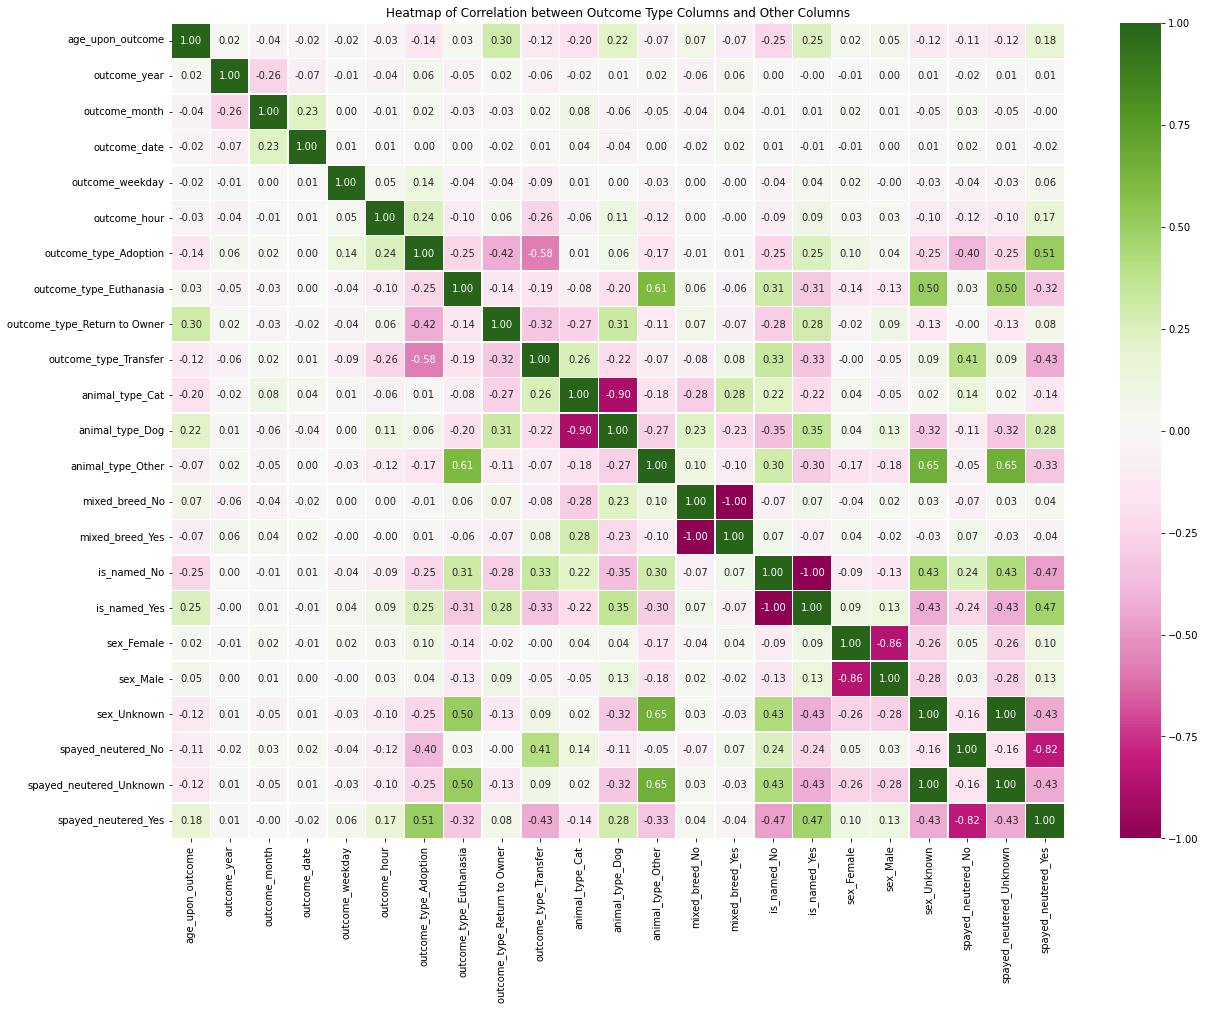

In [119]:
# Computing the correlation matrix
dtf_corr = dtf_encoded.corr(method="pearson")

# Plotting the heatmap
plt.subplots(figsize=(20,15))
sns.heatmap(dtf_corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap="PiYG", cbar=True, linewidths=0.5)
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.show()

We can see that columns like 'outcome_date', 'outcome_month' and 'outcome_year' have little impact on the target features ('outcome_type_Adoption/Euthanasia/Return to Owner/Transfer'), and may not add new insights predicting it. They do have some correlations with each other though (respectively). For instance, there is a correlation of -0.26 between 'outcome_year' and 'outcome_month' (which does makes sense).

-----------------add more comments.

Comparing to 'outcome_subtype' column:

In [120]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'outcome_subtype']

# Encoding columns using one-hot encoding
dtf_encoded_outcome = pd.get_dummies(dtf, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns and outcome subtype columns
outcome_type_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_type' in col]
outcome_subtype_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_subtype' in col]

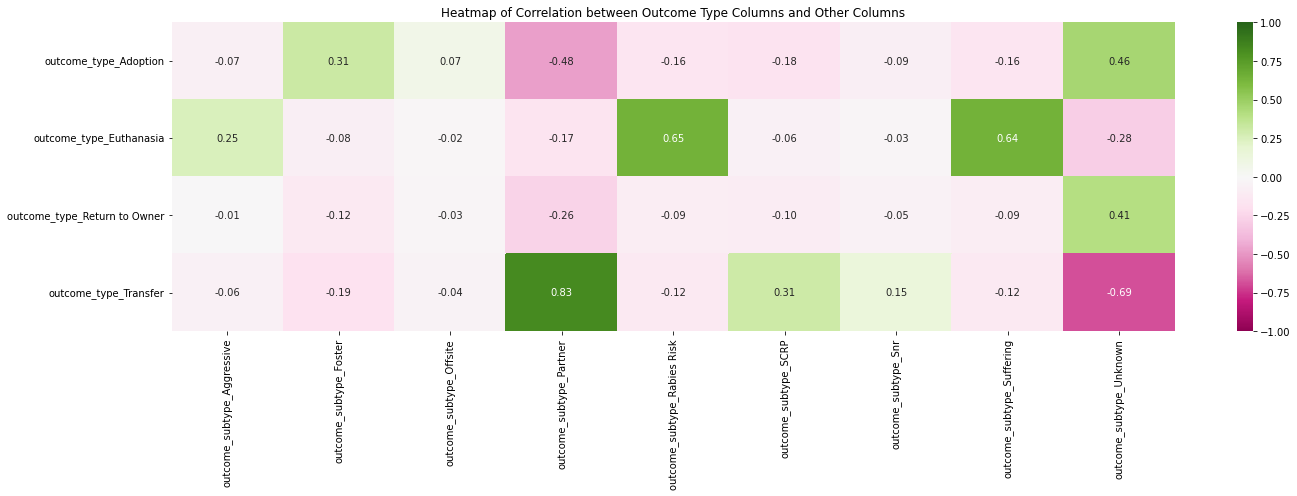

In [121]:
# Computing the correlation matrix
dtf_corr = dtf_encoded_outcome[outcome_type_columns + outcome_subtype_columns].corr(method="pearson")

# Plotting the heatmap
plt.subplots(figsize=(20, 7))
sns.heatmap(dtf_corr.loc[outcome_type_columns, outcome_subtype_columns], vmin=-1, vmax=1, annot=True,
        cmap='PiYG', fmt=".2f")
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.tight_layout()
plt.show()

There is a strong association between 'outcome_subtype_Partner' and 'outcome_type_Transfer', evidenced by a correlation coefficient of 0.83. This suggests that many instances with the outcome type of transfer, predominantly involving cats, have an outcome subtype of partner, indicating a transfer to a partnering shelter. Also, animals associated with 'outcome_subtype_Partner' are less likely to get adopted, as indicated by a correlation of -0.47 with 'outcome_type_Adoption'.

Additionally, animals identified with 'outcome_subtype_Rabies Risk' or 'outcome_subtype_Suffering' demonstrate a higher likelihood of euthanasia, with correlation coefficients of 0.65 and 0.64, respectively, with 'outcome_type_Euthanasia'.

Moreover, animals categorized with 'outcome_subtype_Unknown' are less inclined to be transferred (correlation of -0.69 with 'outcome_type_Transfer') or euthanized (correlation of -0.29 with 'outcome_type_Euthanasia'). Instead, they show potential for being returned to their owners (correlation of 0.41 with 'outcome_type_Return to Owner') or adopted (correlation of 0.47 with 'outcome_type_Adoption').

***

## Improved ML Model

### Training the model and predicting

In [122]:
# Dropping 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# Converting all columns to the category data type
dtf_model = dtf_model.astype('category')

In [124]:
# Columns for one-hot encoding
columns_for_one_hot = ['animal_type', 'breed', 'mixed_breed', 'color1', 'color2', 'is_named', 'outcome_subtype',
                    'outcome_type', 'sex', 'spayed_neutered']

# One-hot encoding
encoded_data = pd.get_dummies(dtf_model[columns_for_one_hot])

# Getting all the target columns (columns that include 'outcome_type' in their name)
outcome_type_columns = [col for col in encoded_data.columns if 'outcome_type' in col]

In [125]:
# Initialize StandardScaler object for feature scaling
scaler = StandardScaler()

# Initialize lists to store accuracy scores
validation_accuracies = []
test_accuracies = []

# Initialize an empty dictionary to store feature importances
feature_importances = {}

<font color='#f542b0'>---------------takes 1.5 minutes. Add a skip option.</font>

In [126]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]

    # Initialize the model
    model = AdaBoostClassifier(n_estimators=250)

    validation_accuracies, test_accuracies, model, feature_importances = fit_and_predict(outcome_column,
                            X, y, validation_accuracies, test_accuracies, scaler, model, feature_importances)

Validation Accuracy for outcome_type_Adoption: 0.8298988621997472
Test Accuracy for outcome_type_Adoption: 0.8333754740834387

Validation Accuracy for outcome_type_Euthanasia: 0.9963337547408344
Test Accuracy for outcome_type_Euthanasia: 0.9967762326169406

Validation Accuracy for outcome_type_Return to Owner: 0.8412136536030341
Test Accuracy for outcome_type_Return to Owner: 0.8398230088495575

Validation Accuracy for outcome_type_Transfer: 0.9808470290771176
Test Accuracy for outcome_type_Transfer: 0.9789506953223768



### Evaluating the model

In [127]:
# Calculate average validation accuracy
avg_val_accuracy = np.mean(validation_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy}")

# Calculate average test accuracy
avg_test_accuracy = np.mean(test_accuracies)
print(f"Average Test Accuracy: {avg_test_accuracy}")

Average Validation Accuracy: 0.9120733249051833
Average Test Accuracy: 0.9122313527180784


In [128]:
# Define the number of top features to display
top_n_features = 15

# Calculate average feature importances across all outcome types
avg_feature_importances = np.mean([importances for importances in feature_importances.values()], axis=0)

# Sort and get the indices of top N most important features
top_feature_indices = avg_feature_importances.argsort()[-top_n_features:][::-1]

In [129]:
# Print top N most important features
print(f"Top {top_n_features} most important features:\n")

for index in top_feature_indices:
    print(f"{X.columns[index]}: {avg_feature_importances[index]}")

Top 15 most important features:

breed_Domestic Shorthair: 0.16999999999999998
animal_type_Cat: 0.167
breed_Domestic Mediumhair: 0.059
breed_Domestic Longhair: 0.05499999999999999
breed_Siamese: 0.040999999999999995
animal_type_Other: 0.027
color1_Other color: 0.017
outcome_subtype_Unknown: 0.015000000000000001
outcome_subtype_Aggressive: 0.015
breed_Pit Bull: 0.013999999999999999
color1_Tricolor: 0.013000000000000001
breed_Labrador Retriever: 0.012
breed_Rabbit: 0.012
spayed_neutered_Yes: 0.012
outcome_subtype_Rabies Risk: 0.012


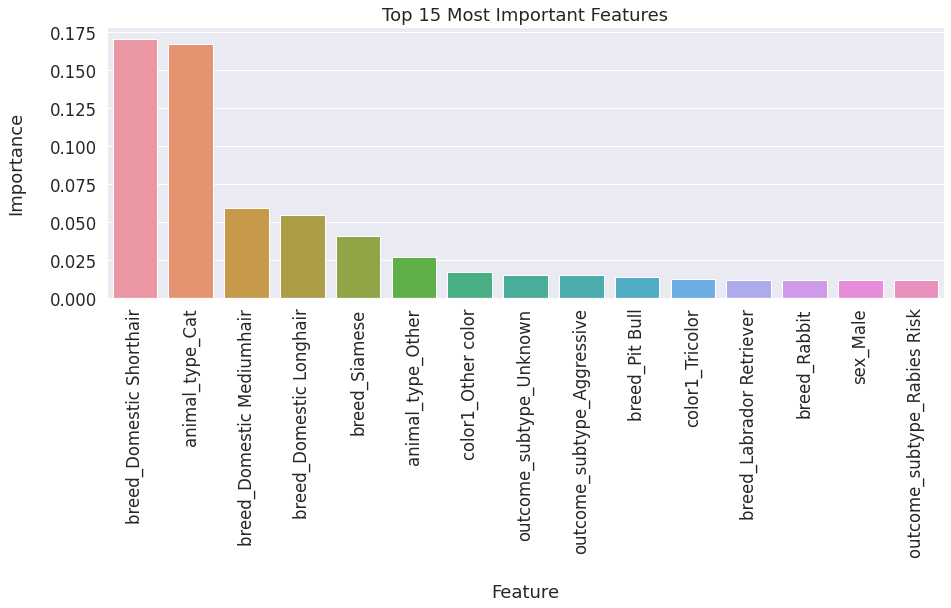

In [130]:
# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'importance': avg_feature_importances[top_feature_indices],
                               'feature': np.array(encoded_data.columns)[top_feature_indices]})

# Set seaborn font scale
sns.set(font_scale=1.50)

# Create a bar plot of top N most important features
plt.figure(figsize=(15, 5))
sns.barplot(x='feature', y='importance', data=importances_df)
plt.xticks(rotation=90)
plt.xlabel('Feature', labelpad=25)
plt.ylabel('Importance', labelpad=25)
plt.title(f'Top {top_n_features} Most Important Features')
plt.show()